<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 15


In [1]:
import sys
sys.path.append("../")

In [2]:
from itertools import cycle, islice
import numpy as np

In [3]:
from sklearn import mixture
from sklearn import metrics
from pomegranate import *

In [4]:
from scipy.stats import kde
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [5]:
from helpers import read_configuration_file, INFO, WARNING
from train import main
from train import load_regions
from hmm_helpers import build_hmm
from hmm_helpers import get_window_ids_from_viterbi_path
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [6]:
sns.set(color_codes=True)

In [7]:
def load_data_file(filename):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        region_means = [float(item) for item in arraystr]
        return region_means

In [8]:
# change the paths here accordingly 

wga_mean_tuf_I_file = "/home/david/Desktop/wga_windows_mean_0_TUF_DETAIL_I.txt"
no_wga_mean_tuf_I_file = "/home/david/Desktop/no_wga_windows_mean_0_TUF_DETAIL_I.txt"
#gc_tuf_I_file = "/home/david/Desktop/windows_gc_0_TUF_DETAIL_I.txt"

#wga_mean_tuf_II_file = "/home/a/ag568/wga_windows_mean_0_TUF_DETAIL_II.txt"
#no_wga_mean_tuf_II_file = "/home/a/ag568/no_wga_windows_mean_0_TUF_DETAIL_II.txt"
#gc_tuf_II_file = "/home/a/ag568/windows_gc_0_TUF_DETAIL_II.txt"

wga_mean_single_copy_deletion_file = "/home/david/Desktop/wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
no_wga_mean_single_copy_deletion_file = "/home/david/Desktop/no_wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
#gc_single_copy_deletion_file = "/home/david/Desktop/windows_gc_0_SINGLE_COPY_DELETION.txt"

wga_mean_duplication_file = "/home/david/Desktop/wga_windows_mean_0_DUPLICATION.txt"
no_wga_mean_duplication_file = "/home/david/Desktop/no_wga_windows_mean_0_DUPLICATION.txt"
#gc_duplication_file = "/home/david/Desktop/windows_gc_0_DUPLICATION.txt"

wga_mean_delete_file = "/home/david/Desktop/wga_windows_mean_0_DELETE.txt"
no_wga_mean_delete_file = "/home/david/Desktop/no_wga_windows_mean_0_DELETE.txt"
#gc_delete_file = "/home/david/Desktop/windows_gc_0_DELETE.txt"

In [9]:
wga_mu_tuf_I = load_data_file(filename=wga_mean_tuf_I_file)
no_wga_mu_tuf_I = load_data_file(filename=no_wga_mean_tuf_I_file)
#gc_tuf_I = load_data_file(filename=gc_tuf_I_file)

wga_mu_single_copy_deletion = load_data_file(filename=wga_mean_single_copy_deletion_file)
no_wga_mu_single_copy_deletion = load_data_file(filename=no_wga_mean_single_copy_deletion_file)
#gc_single_copy_deletion = load_data_file(filename=gc_single_copy_deletion_file)

wga_mu_duplication = load_data_file(filename=wga_mean_duplication_file)
no_wga_mu_duplication = load_data_file(filename=no_wga_mean_duplication_file)
#gc_duplication = load_data_file(filename=gc_duplication_file)

wga_mu_delete = load_data_file(filename=wga_mean_delete_file)
no_wga_mu_delete = load_data_file(filename=no_wga_mean_delete_file)
#gc_delete = load_data_file(filename=gc_delete_file)

In [10]:
# mix the data

# WGA sample
wga_mu = []
#wga_mu.extend(wga_mu_tuf_I)
#wga_mu.extend(wga_mu_tuf_II)
wga_mu.extend(wga_mu_single_copy_deletion)
wga_mu.extend(wga_mu_duplication)
wga_mu.extend(wga_mu_delete)


# NO-WGA sample
no_wga_mu = []
#no_wga_mu.extend(no_wga_mu_tuf_I)
#no_wga_mu.extend(no_wga_mu_tuf_II)
no_wga_mu.extend(no_wga_mu_single_copy_deletion)
no_wga_mu.extend(no_wga_mu_duplication)
no_wga_mu.extend(no_wga_mu_delete)


# GC
#gc = []
#gc.extend(gc_tuf_I)
#gc.extend(gc_tuf_II)
#gc.extend(gc_single_copy_deletion)
#gc.extend(gc_duplication)
#gc.extend(gc_delete)

In [11]:
def make_data_array(wga_mu, no_wga_mu, gc, use_ratio, use_gc):
    data = []
    
    if use_ratio and use_gc:
        for no_wga_val, wga_val,gc_val in zip(no_wga_mu, wga_mu, gc):
            data.append([no_wga_val, wga_val, (wga_val + 1)/(no_wga_val + 1), gc_val])
    elif use_ratio:
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga,  (wga + 1)/(no_wga + 1)])
    elif use_gc:
        
        for no_wga_val, wga_val , gc_val in zip(no_wga_mu, wga_mu,  gc):
            data.append([no_wga_val, wga_val, gc_val])
    else:
        
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga ])
        
    return data

In [12]:
def gmm_clustering(clusters, data, cov_type, tol, max_itrs, 
                   n_init, no_wga_mu, wga_mu, xlim, ylim, nbins=80 ):
    
    #for nclusters in clusters:
    
        #means_initarray = np.array([[10.0, 10.0],
        #                            [1.39622167e-20, 1.39521042e-20],
        #                            [39.63216969, 24.28369249],
        #                            [16.6581865,  13.75347261],
        #                            [19.64182959, 23.31839897]])
    
        print("Number of clusters ", clusters)
        gmm = mixture.GaussianMixture(n_components=clusters,
                                      covariance_type=cov_type,
                                      tol=tol, max_iter=max_itrs,
                                      n_init=n_init)# means_init=means_initarray)
        gmm.fit(data)
        print("Converged: ", gmm.converged_)
        print("BIC: ", gmm.bic(data))
        labels = gmm.predict(data)
        
        print("Len of labels: ", len(labels))

        colors = np.array(['green', 'blue', 'red', 
                           'yellow', 'pink', 'orange', 'purple', 'navy',
                          'brown'])

        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        colors = colors[labels]
       
        plt.scatter(no_wga_mu, wga_mu,  color=colors)
        
        #kernel= kde.gaussian_kde(np.vstack([no_wga_mu, wga_mu]))
        #xi, yi = np.mgrid[min(no_wga_mu):max(no_wga_mu):nbins*1j, 
        #                  min(wga_mu):max(wga_mu):nbins*1j]
        
        #zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        
        #plt.contour(xi, yi, zi.reshape(xi.shape), 24 )
        
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()
        
        # map that holds the association between the
        # component color and component index
        
        color_comp_assoc = {}
        for label, color in zip(labels, colors):
            if color in color_comp_assoc.keys():
                assert color_comp_assoc[color][0] == label
                color_comp_assoc[color][1] += 1
            else:
                color_comp_assoc[color] = [label, 1]
        
        return gmm, labels, color_comp_assoc

## Cluster the reference data

In [13]:
# Dictionay that holds the states for the HMM 
states={}

In [14]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

Number of clusters  5
Converged:  True
BIC:  154276.26381722552
Len of labels:  11741


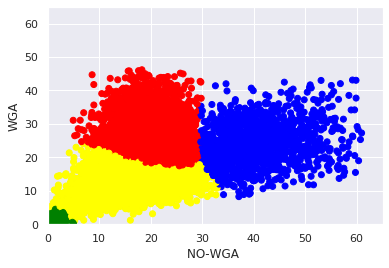

Color-cluster association {'yellow': [3, 5737], 'red': [2, 4141], 'blue': [1, 1288], 'green': [0, 355], 'pink': [4, 220]}


In [15]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=5, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=500, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 65.0),
                                                 ylim=(0., 65.0))

print("Color-cluster association", color_comp_assoc)

This depends on the clustering above so we need to make sure that colors do align

In [16]:
means = gmm.means_

for i in range(len(means)):
    print("{0} Component {1} means {2} ".format(INFO, i , means[i]))

covariances = gmm.covariances_

INFO: Component 0 means [0.95950104 0.97196588] 
INFO: Component 1 means [39.63145327 24.2837122 ] 
INFO: Component 2 means [19.64183047 23.32141686] 
INFO: Component 3 means [16.65967075 13.75511102] 
INFO: Component 4 means [1.39435989e-20 1.39334727e-20] 


In [17]:
states_map = {"Duplication": 1, "Normal-I": 3, 
              "Normal-II": 2, "Deletion": 0}

state name:  Duplication
State means:  [39.63145327 24.2837122 ]
State covariance:  [71.55929894 39.46914488]


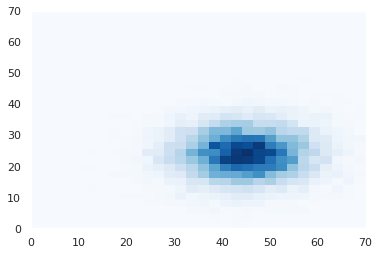

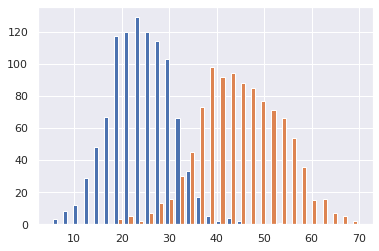

state name:  Normal-I
State means:  [16.65967075 13.75511102]
State covariance:  [31.47970957 19.02920145]


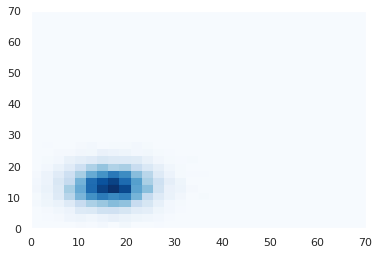

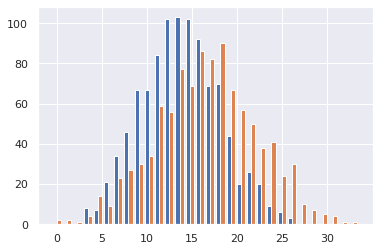

state name:  Normal-II
State means:  [19.64183047 23.32141686]
State covariance:  [19.60139758 52.48642032]


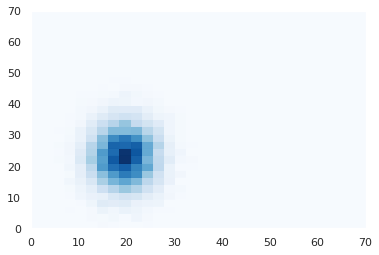

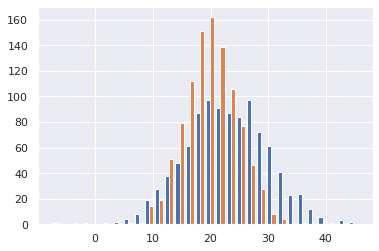

state name:  Deletion
State means:  [0.95950104 0.97196588]
State covariance:  [1.19657728 1.10845202]


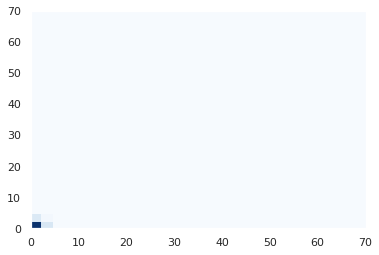

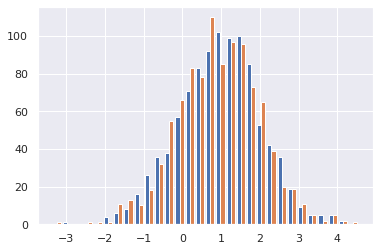

In [18]:


for state in states_map:
    
    print("state name: ", state)
    name = state
    idx = states_map[state]
    
    # change the order of the means to match the order of the
    # data we will retrieve below in the prediction step
    mu_no_wga = means[idx][0]
    mu_wga = means[idx][1]
    mu = np.array([mu_wga, mu_no_wga])
    print("State means: ", means[idx])
    cov = covariances[idx]
    print("State covariance: ", cov)
    cov = np.array([[cov[1], 0.0], [0.0, cov[0]]])
    
    
    if state == "Duplication":
        mu[1] = 45.0
    
    state_dist = MultivariateGaussianDistribution(means=mu,
                                                  covariance=cov)
    
    if state == "Duplication":
        min_ = 0.0
        max_ = 70.0
    elif state == "Normal-I":
        min_ = 0.0
        max_ = 70.0
    elif state == "Normal-II":
        min_ = 0.0
        max_ = 70.0
    elif state == 'Deletion':
        min_ = 0.0
        max_ = 70.0
    
    n_bins = 30
    samples = state_dist.sample(n=10000)
    xdata = samples[:,[0]]
    ydata = samples[:,[1]]
    
    x = [item[0] for item in xdata]
    y = [item[0] for item in ydata]
    #print(samples)
    plt.hist2d(y, x,
                 bins=[n_bins, n_bins], cmap='Blues', density=False,
                 #cmax=1000,
                 #cmin=0,
                 alpha=0.99,
                 range=((min_, max_), (min_, max_)))
  
    plt.show()
    state_dist.plot(bins=n_bins)
    plt.show()

    states[name]  = State(state_dist, name=name)
    

### Cluster for TUF

Simply use the ref TUF I region to extract the distribution.

In [19]:
tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf_I)

tuf_no_wga_mu = []
tuf_no_wga_mu.extend(no_wga_mu_tuf_I)

In [20]:
tuf_data = make_data_array(wga_mu=tuf_wga_mu, 
                       no_wga_mu=tuf_no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

tuf_data = np.array(tuf_data)

assert tuf_data.shape == (len(tuf_wga_mu), 3)

Number of clusters  3
Converged:  True
BIC:  15265.074903928284
Len of labels:  1231


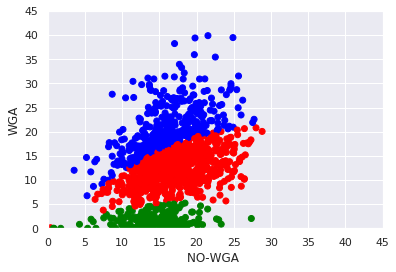

In [21]:
gmm_tuf, labels_tuf, color_comp_assoc_tuf = gmm_clustering(clusters=3, data=tuf_data, tol=1.0e-5, cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=tuf_no_wga_mu, 
                                                 wga_mu=tuf_wga_mu,
                                                 xlim=(0., 45.0),
                                                 ylim=(0., 45.0))

In [22]:
print("Color-cluster association for TUF", color_comp_assoc_tuf)

Color-cluster association for TUF {'blue': [1, 372], 'red': [2, 676], 'green': [0, 183]}


In [23]:
tuf_idx = 0

TUF means:  [14.22026496  1.73454633  0.19150515]
TUF covariances:  [1.56560378e+01 1.92610938e+00 1.10285766e-02]


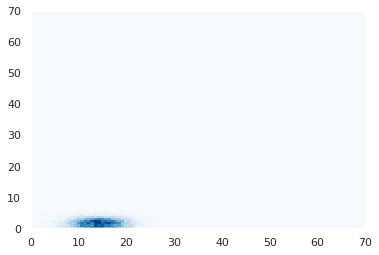

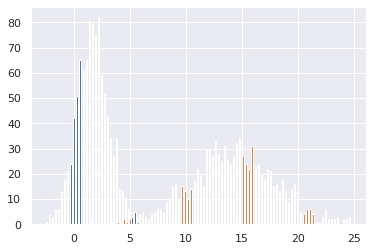

In [24]:
tuf_means = gmm_tuf.means_

print("TUF means: ", tuf_means[tuf_idx])

tuf_cov = gmm_tuf.covariances_

print("TUF covariances: ", tuf_cov[tuf_idx])

tuf_mu_no_wga = tuf_means[tuf_idx][0]
tuf_mu_wga = tuf_means[tuf_idx][1]
tuf_mu = np.array([tuf_mu_wga, tuf_mu_no_wga])
tuf_cov = tuf_cov[tuf_idx]
tuf_cov = np.array([[tuf_cov[1], 0.0], [0.0, tuf_cov[0]]])
name = "TUF"

tuf_dist = MultivariateGaussianDistribution(means=tuf_mu,
                                            covariance=tuf_cov)

n_bins = 100
samples = tuf_dist.sample(n=10000)
xdata = samples[:,[0]]
ydata = samples[:,[1]]
    
x = [item[0] for item in xdata]
y = [item[0] for item in ydata]
    #print(samples)
plt.hist2d(y, x,
           bins=[n_bins, n_bins], cmap='Blues', density=False,
           cmax=1000,
           cmin=0,
           alpha=0.99,
           range=((0.0, 70.), (0.0, 70.0)))
  
plt.show()
tuf_dist.plot(bins=n_bins)
plt.show()

#only change the means
tuf_mu = np.array([tuf_mu_wga, 40.0])

# also add the dist that is not modeled by the data
tuf_dist_double = MultivariateGaussianDistribution(means=tuf_mu,
                                                   covariance=tuf_cov)

tuf_mixture = GeneralMixtureModel([tuf_dist, tuf_dist_double], weights=[0.66, 0.34])
states[name]  = State(tuf_mixture, name=name)


## Apply HMM

In [25]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]

In [26]:
gap_state = None
gap_state_dist = None


In [27]:
if configuration["remove_windows_with_gaps"] == False:
    
    name="GAP_STATE"
    
    # we have a gap state then add it
    gap_windows_dist = configuration["gap_windows_dist"]
    gap_state_dist = get_dist_list(dists_name=[gap_windows_dist["name"],
                                               gap_windows_dist["name"]],
                                               params={"uniform_params":gap_windows_dist["config"]["parameters"]})

    gap_state = \
            State(IndependentComponentsDistribution(gap_state_dist), 
                  name=name)
    states[name] = gap_state

In [28]:
print("{0} Number of states: {1}".format(INFO, len(states)))
for state in states:
    print(state)

INFO: Number of states: 6
Duplication
Normal-I
Normal-II
Deletion
TUF
GAP_STATE


In [29]:
# print info about the states
for name in states:
    state = states[name]
    print("{0} State: {1}".format(INFO, state.name))
    state_map = json.loads(str(state))
    print("{0} Distributions: {1}".format(INFO,
                                          state_map["distribution"]))

# create the HMM
hmm_model = HiddenMarkovModel(name=hmm_config["name"],
                              start=None, end=None)

states_list = []
for state in states:
    states_list.append(states[state])
hmm_model.add_states(states_list)

INFO: State: Duplication
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[24.283712195818197, 45.0], [[39.469144879317014, 0.0], [0.0, 71.55929893640007]]], 'frozen': False}
INFO: State: Normal-I
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[13.755111020324863, 16.659670748600576], [[19.02920145031391, 0.0], [0.0, 31.47970957476321]]], 'frozen': False}
INFO: State: Normal-II
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[23.32141685664695, 19.6418304682281], [[52.48642032002988, 0.0], [0.0, 19.60139758371219]]], 'frozen': False}
INFO: State: Deletion
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[0.9719658790201852, 0.9595010427613282], [[1.1084520242103273, 0.0], [0.0, 1.1965772817643188]]], 'frozen': False}
INFO: State: TUF
INFO: Distributions: {'cl

In [30]:
# uniform probability for starting the sequence
# for every state
start_prob = 1.0/len(states)
hmm_config["states"]={}

for state in states:
    hmm_config["states"][state] = {"start_prob":start_prob}

In [31]:
print("Startring probabilities....")
for state in states:
    print("State: {0}, probability: {1} ".format(state,hmm_config["states"][state]["start_prob"]))
    

Startring probabilities....
State: Duplication, probability: 0.16666666666666666 
State: Normal-I, probability: 0.16666666666666666 
State: Normal-II, probability: 0.16666666666666666 
State: Deletion, probability: 0.16666666666666666 
State: TUF, probability: 0.16666666666666666 
State: GAP_STATE, probability: 0.16666666666666666 


Form the transition probabilities

In [32]:
self_trans = 0.85
off_trans = (1.0 - self_trans)/(len(states) - 1)

print("Self transition: ", self_trans)
print("Off transition: ", off_trans)

hmm_config["transitions"]={}

for state_i in states:
    for state_j in states:
        state_name = state_i + "-" + state_j
        if state_i == state_j:
            hmm_config["transitions"][state_name] = self_trans
        else:
            hmm_config["transitions"][state_name] = off_trans

Self transition:  0.85
Off transition:  0.030000000000000006


In [126]:
# change the transitions for TUF
#for state_i in states:
#    for state_j in states:
#        state_name = state_i + "-" + state_j
        
#        if state_i == 'TUF':
            
            # more likely to transition from TUF to Normal
            # than Delete and Duplication or GAP_STATE
#            if state_j == 'Normal-I' or state_j == 'Normal-I':
#                hmm_config["transitions"][state_name] = 0.05
#            elif state_j == 'Delete' or state_j == 'Duplication' or state_j == 'GAP_STATE':
#                hmm_config["transitions"][state_name] = 0.003
#        if state_i == 'Duplication':
             # more likely to transition from Duplication to Normal
            # than Delete and TUF or GAP_STATE
#            if state_j == 'Normal-I' or state_j == 'Normal-I':
#                hmm_config["transitions"][state_name] = 0.05
#            elif state_j == 'Delete' or state_j == 'TUF' or state_j == 'GAP_STATE':
#                hmm_config["transitions"][state_name] = 0.003

In [33]:
for state in states:
    prob = hmm_config["states"][state]["start_prob"]
    hmm_model.add_transition(hmm_model.start, states[state], prob)

# add transitions for every state
# to another this will create a dense HMM
for state_i in states:
    for state_j in states:
        if state_i + "-" + state_j in hmm_config["transitions"]:
                prob =hmm_config["transitions"][state_i + "-" + state_j]
                hmm_model.add_transition(states[state_i], states[state_j], prob)
        else:
                print("{0} Transition from state"
              " {1} to state {2} is not specified".format(WARNING,
                                                          state_i,
                                                          state_j))



In [34]:
# finally we need to bake
hmm_model.bake(verbose=True)

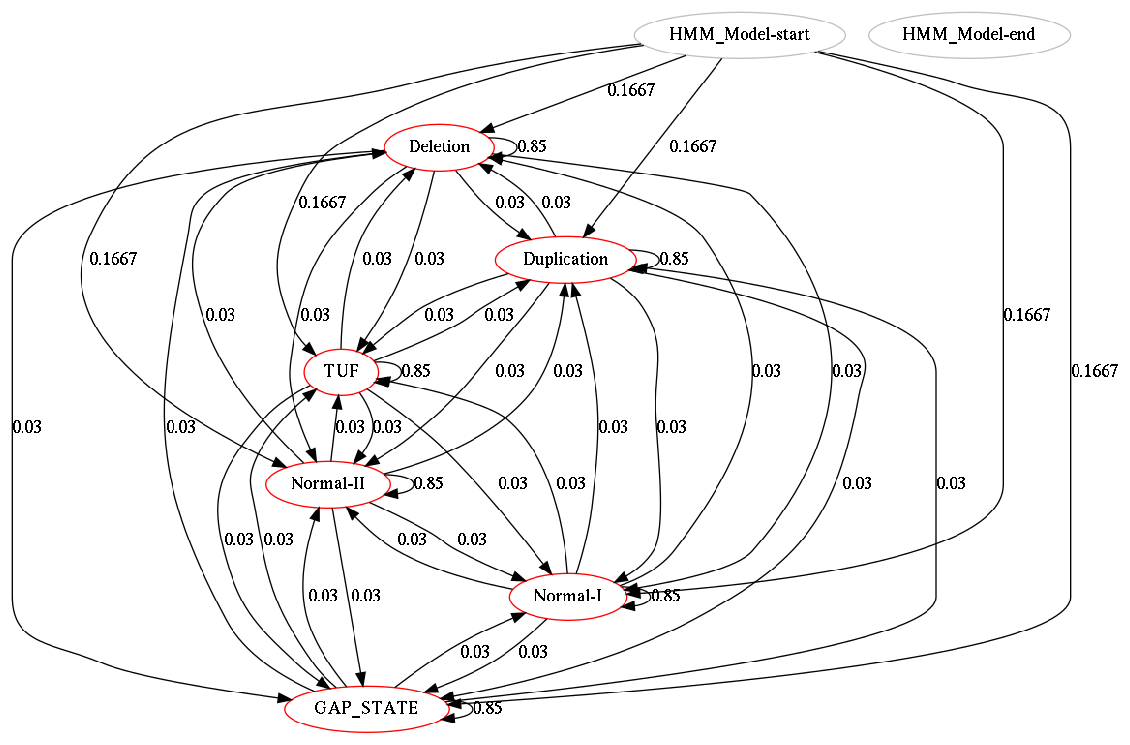

In [79]:
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

In [80]:
hmm_model.dense_transition_matrix()

array([[0.85      , 0.03      , 0.03      , 0.03      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.85      , 0.03      , 0.03      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.85      , 0.03      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.03      , 0.85      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.03      , 0.03      , 0.85      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.03      , 0.03      , 0.03      ,
        0.85      , 0.        , 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [131]:
json_str = hmm_model.to_json()
import json
with open("HMM_Model_3_GMM_TUF_INCREASE_DUP_NO_WGA" + ".json", 'w') as jsonfile:
      json.dump(json_str, jsonfile)

## HMM Predict

Load same region with decreased outlier margin to $5\sigma$

In [35]:
region_name = "region_0_REGION_1_5S.txt"
region_file = "/home/david/Desktop/" + region_name
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

INFO: Loading region from file: /home/david/Desktop/region_0_REGION_1_5S.txt


In [36]:
# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

Sequence length:  189230


In [37]:
observations = []
for i in range(len(sequence)):
    observations.append(sequence[i][0])

print("Observation length: ", len(observations))

time_start = time.perf_counter()
viterbi_path = hmm_model.viterbi(observations)
time_end = time.perf_counter()
print("Done. Execution time"
          " {0} secs".format(time_end - time_start))
print("Log-probability of ML Viterbi path: ", viterbi_path[0])

# for each item in the sequence
# cache the index and state predicted
sequence_viterbi_state = []

if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))

        filename="viterbi_path_TUF_GMM_INCREASE_NO_WGA_" + region_name
        counter = 0
        with open(filename, 'w') as f:
            f.write(str(len(viterbi_path[1])-1) + "\n")
            for item in range(len(sequence)):

                if sequence[item][0] == (-999.0, -999.0):
                    counter += 1

                f.write(str(item)+ ":" + str(sequence[item][1]) + ":" + str(sequence[item][0]) + ":" + viterbi_path[1][item+1][1].name + "\n")
                sequence_viterbi_state.append((item, viterbi_path[1][item+1][1].name))
                
                #print("sequnce item: {0} state {1}".format(sequence[item], viterbi_path[1][item+1][1].name))
        print("There should be {0} gaps".format(counter))
else:
        print("Viterbi path is impossible for the given sequence")

Observation length:  189230
Done. Execution time 0.9152985789987724 secs
Log-probability of ML Viterbi path:  -1229436.9782605655
Viterbi path length:  189231
There should be 1438 gaps


In [65]:
from IPython.core.debugger import set_trace

def is_solid_subseq(subseq, wstate):
    
    itis = True
    for sitem in subseq: 
        if sitem[1].name != wstate:
            itis = False
            break
    return itis

def clean_up_subsequence(subseq, start):
    indices = []
    
    for item in subseq:
        indices.append((start, item[1].name))
        start += 1
    return indices

def get_state_bwd(path, counter_end, wstate):
    indices = []
    global_end = counter_end
    for item in reversed(path):
        if item[1].name == wstate:
            indices.append((global_end, wstate))
        else:
            break
        global_end -= 1
    if len(indices) != 0:
        return indices[::-1]
    return indices

def get_state_fwd(path, counter_start, wstate):
    
    indices = []
    global_start = counter_start
    for item in path:
        
        #if global_start == 226:
        #    set_trace()
        
        if item[1].name == wstate:
            indices.append((global_start, item[1].name))
        else:
            break
        global_start += 1
    return indices

def check_items(included, check_on):
    
    if check_on[-1][0] in included:
        # if the last is included all
        # the rest should be
        return True
    # are not in so put it in
    for item in check_on:
        included.append(item[0])
    return False

def filter_viterbi_path(path, wstate, limit_state, min_subsequence):
    
    print("Length of path ", len(path))
    
    indices = []
    
    index_included = []
    path_counter = 0
    stop = False
    while not stop:
        
        if path_counter >= len(path):
            break
        
        #print("Path counter ", path_counter)
        
        # get the item from the viterbi path
        item = path[path_counter]
        
        #if path_counter == 195:
        #    set_trace()
        
        # if this is the last item treat it differently
        # as we don't have any forward items
        if path_counter == len(path) -1:
            #regardless of what this is ignore it
            break
       
        if item[1].name == limit_state:
                
                #we don't want to fall off the array
                if min_subsequence + path_counter >= len(path):
                    break
                    
                # get the subsequence
                subsequence = path[path_counter:min_subsequence + path_counter]
                
                # only do work if it is pure
                if is_solid_subseq(subseq=subsequence, wstate=limit_state):
                    
                    subsequence = clean_up_subsequence(subseq=subsequence, start=path_counter)
                    
                    # what is after the extracted region
                    counter_after = path_counter + min_subsequence

                    # check what is after the extracted region
                    has_wstate_after = False
                    has_limit_state_after = False
                    
                    if path[counter_after][1].name == wstate:
                        #this is an island
                        has_wstate_after = True
                    elif path[counter_after][1].name == limit_state:
                        has_limit_state_after = True
                
                    # check what is before the extracted
                    # region
                    has_wstate_before = False

                    if path[ path_counter - 1 ][1].name == wstate:
                        has_wstate_before = True

                    if has_wstate_before and has_wstate_after:
                        # subsequence is an island get the
                        # surrounding TUFs
                        tuf_before = get_state_bwd(path=path[:path_counter], 
                                                   counter_end=path_counter-1,
                                                   wstate=wstate)
                        tuf_after = get_state_fwd(path=path[counter_after:], 
                                                  counter_start=counter_after,
                                                  wstate=wstate)
                        if check_items(included=index_included, check_on=tuf_before) == False:
                            indices.extend(tuf_before)
                        indices.extend(subsequence)
                        indices.extend(tuf_after)
                        
                        path_counter += min_subsequence + len(tuf_after)
                        
                    elif has_wstate_before and has_limit_state_after:
                        # pick up all the limit_wstate as these are part 
                        # of the island
                        limit_state_after = get_state_fwd(path=path[counter_after:], 
                                                          counter_start=counter_after,
                                                          wstate=limit_state)
                        counter_after += len(limit_state_after)
                        
                        # only if the exactly next one is wstate
                        # then we have an island
                        if path[counter_after][1].name == wstate:
                            
                            tuf_before = get_state_bwd(path=path[:path_counter],
                                                       counter_end=path_counter-1,
                                                       wstate=wstate)
                            
                            tuf_after = get_state_fwd(path=path[counter_after:], 
                                                      counter_start=counter_after,
                                                      wstate=wstate)
                            subsequence.extend(limit_state_after)
                            
                            if check_items(included=index_included, check_on=tuf_before) == False:
                                indices.extend(tuf_before)
                            
                            indices.extend(subsequence)
                            indices.extend(tuf_after)
                            path_counter += len(subsequence) + len(tuf_after)
                        else:
                            # jump to counter_after
                            # as did a search and there are no islands
                            path_counter = counter_after
                    else:
                        
                        path_counter += 1
                
                    
                else:
                        path_counter += 1
        else:
            
            #simply increase the counter
            path_counter += 1
                        
    return indices


def get_continuous(tuf_delete_tuf, start_tuf_counter, name):
    
    has_more = True
    item = None
    counter = start_tuf_counter
    while has_more:
        
        if counter >= len(tuf_delete_tuf):
            break
        
        new_item = tuf_delete_tuf[counter]
        
        if new_item[1] != name:
            has_more = False
        
        else:
            item = new_item
            counter += 1
    return item, counter
            
            
def get_start_end_segment(tuf_delete_tuf, sequence):
    
    #set_trace()
    start_tuf_counter = 0
    segments = []
    while True:
        
        #print("Start tuf counter is ", start_tuf_counter)
        
        #if start_tuf_counter == 2762:
        #    set_trace()
        
        start_item = tuf_delete_tuf[start_tuf_counter]
        start_seq = sequence[start_item[0]]
        
        end_item, counter = get_continuous(tuf_delete_tuf=tuf_delete_tuf, 
                                           start_tuf_counter=start_tuf_counter+1,
                                           name=start_item[1])
        #print("Counter is: ", counter)
        #print(start_item)
        if end_item is not None:
            assert end_item[1] == start_item[1]
            end_seq = sequence[end_item[0]]
        
        
            segments.append((start_item[0], int(start_seq[1][0]), 
                            int(end_seq[1][1]), int(end_seq[1][1]) - int(start_seq[1][0]), start_item[1]))
        else:
            # this is on its own
            segments.append((start_item[0], int(start_seq[1][0]), int(start_seq[1][1]), 0, start_item[1]))
        
        
        start_tuf_counter = counter
        
        if start_tuf_counter >= len(tuf_delete_tuf):
            break
        
    return segments
        
        
    

In [66]:

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)
#print(tuf_sequence)
print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))
#print("TUF sequence", tuf_sequence)
segments = get_start_end_segment(tuf_delete_tuf, sequence)
#print(segments)

Length of path  189230
Length of TUF+DELETION+TUF state:  6506


In [67]:
import csv
filename="tuf_delete_tuf_TUF_GMM_INCREASE_NO_WGA_D_1_" + region_name
chromosome = 'chr1'
with open(filename, 'w', newline='\n') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    #segments = get_start_end_segment()
    #for item in tuf_delete_tuf:
    for segment in segments:
        
        row = [chromosome]
        row.extend(list(segment))
        #print(sequence_item)
        #row = (item[0], int(sequence_item[1][0]), int(sequence_item[1][1]), item[1])
        writer.writerow(row)
        

# GC for the region
#gc_filename="/home/david/Desktop/windows_gc_0_REGION_1_5S.txt"

# load the GC file for the region
# this one does not have gaps
#region_gc = load_data_file(filename=gc_filename)

#print("Length of region_gc ", len(region_gc))
#print("Length of sequence ", len(sequence))

#local_to_global = 0
#map_sequence = {}

# we must adjust the indices
#for i, item in enumerate(sequence):
    
#    if i in map_sequence:
#        raise ValueError("Key already exists")
#    else:
        
        # if the sequence says this is a gap
        # then we won't have the GC content anyway
#        if sequence[i][0] != (-999.0, -999.0):  
#            map_sequence[i] = local_to_global
#            local_to_global += 1

#gc_tuf = []
#gc_delete = []

#for item in tuf_sequence:
#    if item[0] in map_sequence:
#        if item[1] == 'TUF':
#            gc_tuf.append(region_gc[map_sequence[item[0]]])
#        elif item[1] == 'Deletion':
#            gc_delete.append(region_gc[map_sequence[item[0]]])
#    else:
#        print("Item {0} not in map_sequence ".format(item))
   
# plot the gc content for TUF
#sns.distplot(gc_tuf, bins=35, kde=False, rug=True)
#plt.show()

#sns.distplot(gc_delete, bins=35, kde=False, rug=True)
#plt.show()
    
#import csv
#filename="tuf_path_TUF_GMM_INCREASE_NO_WGA_" + region_name
#with open(filename, 'w', newline='\n') as csvfile:
#    writer = csv.writer(csvfile, delimiter=',')
#    gc_tuf_counter = 0
#    gc_delete_counter = 0
#    for item in tuf_sequence:
#        if item[1] == 'TUF':
#            row = (item[0], item[1], gc_tuf_counter, gc_tuf[gc_tuf_counter])
#            gc_tuf_counter += 1
            
#        elif item[1] == 'Deletion':
#            row = (item[0], item[1], gc_delete_counter, gc_delete[gc_delete_counter])
#            gc_delete_counter += 1
#        writer.writerow(row)

In [45]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  187792
Encountered gaps:  1438


In [46]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0}

test_individually = []

# collect counters for error statistics
for i, obs in enumerate(observations):
    
    # what dows the Viterbi path says
    viterbi_state = sequence_viterbi_state[i][1]
    if obs == (-999.0, -999.0):
        
        # if we predict that increase the success 
        # otherwise increase errors
        if viterbi_state == 'GAP_STATE':
            states_counter[viterbi_state] += 1
        else:
            states_counter["GAP_STATE_INCORRECT"] += 1
    else:
        states_counter[viterbi_state] += 1  
        
        if viterbi_state == 'Duplication':
            if obs[0] >= 1.5 and obs[0] <3.0 and \
                obs[1] >= 30.0 :
                test_individually.append((i, obs))
                
print(states_counter)             

{'Duplication': 1043, 'Normal-I': 77803, 'Normal-II': 95896, 'Deletion': 467, 'Single-Deletion': 0, 'TUF': 12583, 'GAP_STATE': 1438, 'GAP_STATE_INCORRECT': 0}


In [138]:
print("Items for individual test: ", len(test_individually))
print(test_individually)

Items for individual test:  0
[]


In [139]:
# let's do a viterbi path on their own
special_sequence = []
for item in test_individually:
    special_sequence.append(item[1])
    
print("Special sequence length: ", len(special_sequence))
special_viterbi_path = hmm_model.viterbi(special_sequence)
print("Log-probability of ML Viterbi path: ", viterbi_path[0])

if special_viterbi_path[1] is not None:
        print("Viterbi path length: ", len(special_viterbi_path[1]))
 
        for item in range(len(special_viterbi_path[1])):
        
            if item != 0:
                print("i: {0}, means {1}, state {2}".format(item, special_sequence[item-1], 
                                                            special_viterbi_path[1][item][1].name))
            
else:
        print("Viterbi path is impossible for the given sequence")

Special sequence length:  0
Log-probability of ML Viterbi path:  -1229459.470921616
Viterbi path length:  1


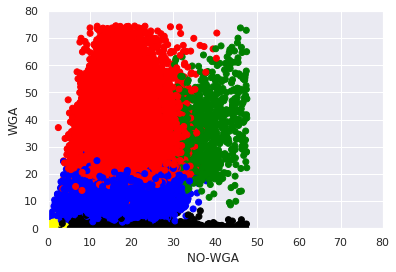

In [140]:
hmm_labels = []
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5}

# collect the labels as these are predicted by the HMM
for i, obs in enumerate(observations):
        
        # do not account for GAPs
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            hmm_labels.append(hmm_states_to_labels[viterbi_state])


colors = np.array(['green', 'blue', 'red', 'yellow', 'pink', 'black'])
colors = colors[hmm_labels]
       
plt.scatter(no_wga_obs, wga_obs,  color=colors)
                
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(0.0, 80.0)
plt.ylim(0.0, 80.0)
plt.show()

color_comp_assoc_hmm = {}
for label, color in zip(hmm_labels, colors):
    if color in color_comp_assoc_hmm.keys():
        assert color_comp_assoc_hmm[color][0] == label
        color_comp_assoc_hmm[color][1] += 1
    else:
        color_comp_assoc_hmm[color] = [label, 1]
print("HMM labels color: ", color_comp_assoc_hmm)

In [141]:
print("HMM labels color: ", color_comp_assoc_hmm)

HMM labels color:  {'black': [5, 12583], 'blue': [1, 95924], 'yellow': [3, 467], 'green': [0, 1043], 'red': [2, 77775]}


State:  Duplication
Length: 1062


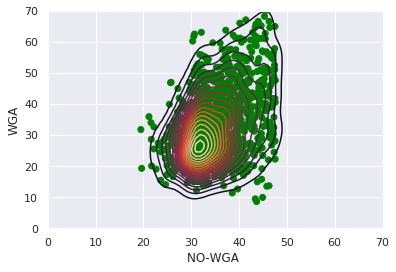

State:  Normal-I
Length: 95855


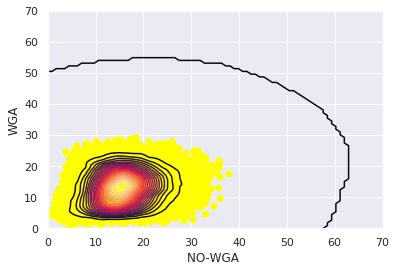

State:  Normal-II
Length: 77691


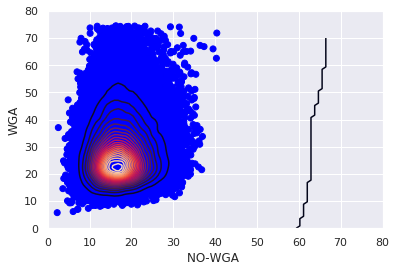

State:  Deletion
Length: 465


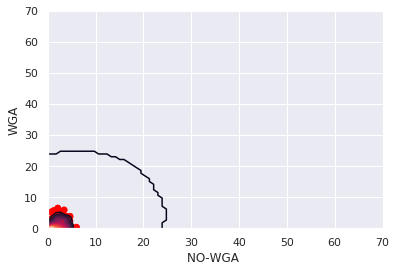

State:  Single-Deletion
For state: Single-Deletion could not plot empty observations
State:  TUF
Length: 12719


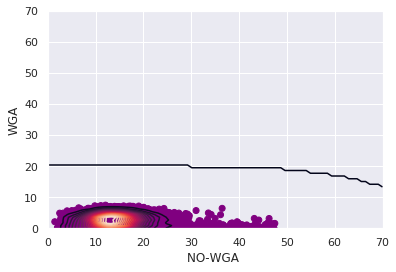

In [82]:
for label in hmm_states_to_labels:
    
    print("State: ", label)
    label_idx = hmm_states_to_labels[label]
    
    state_labels = []
    
    state_no_wga_obs = []
    state_wga_obs = []
    for i, item in enumerate(hmm_labels):
        if item == label_idx:
            state_labels.append(label_idx)
            state_no_wga_obs.append(no_wga_obs[i])
            state_wga_obs.append(wga_obs[i])
       
    
    colors = np.array(['green', 'yellow', 'blue', 'red', 'pink', 'purple'])
    
    if len(state_no_wga_obs) != 0:
        
        print("Length: {0}".format(len(state_no_wga_obs)))
       
        
        colors = colors[state_labels]
    
        # plot the observations
        plt.scatter(state_no_wga_obs, state_wga_obs,  color=colors)
        
        kernel= kde.gaussian_kde(np.vstack([state_no_wga_obs, state_wga_obs]))
        #xi, yi = np.mgrid[min(state_no_wga_obs):max(state_no_wga_obs):nbins*1j, 
        #                       min(state_wga_obs):max(state_wga_obs):nbins*1j]
        
        xi, yi = np.mgrid[min([0.0]):max([70.0]):nbins*1j, 
                               min([0.0]):max([70.0]):nbins*1j]

        zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        plt.contour(xi, yi, zi.reshape(xi.shape), 24 )

        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        
        if label == "Duplication":
            plt.xlim(0.0, 70.0)
            plt.ylim(0.0, 70.0)
        if label == "Normal-I": 
            plt.xlim(0.0, 70.0)
            plt.ylim(0.0, 70.0)
        if label == "Normal-II":
            plt.xlim(0.0, 80.0)
            plt.ylim(0.0, 80.0)
        if label == "Deletion":
            plt.xlim(0.0, 70.0)
            plt.ylim(0.0, 70.0)
        if label == "TUF":
            plt.xlim(0.0, 70.0)
            plt.ylim(0.0, 70.0)
            
        plt.show()
    else:
        print("For state: {0} could not plot empty observations".format(label))

#### Region with window size 200

In [142]:
region_name = "region_0_REGION_1_5S_200WS.txt"
region_file = "/home/david/Desktop/" + region_name
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

INFO: Loading region from file: /home/david/Desktop/region_0_REGION_1_5S_200WS.txt


In [143]:
# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

Sequence length:  94588


In [144]:
observations = []
for i in range(len(sequence)):
    observations.append(sequence[i][0])

print("Observation length: ", len(observations))

time_start = time.perf_counter()
viterbi_path = hmm_model.viterbi(observations)
time_end = time.perf_counter()
print("Done. Execution time"
          " {0} secs".format(time_end - time_start))
print("Log-probability of ML Viterbi path: ", viterbi_path[0])

# for each item in the sequence
# cache the index and state predicted
sequence_viterbi_state = []

if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))
        filename="viterbi_path_TUF_GMM_INCREASE_NO_WGA_" + region_name 
        counter = 0
        with open(filename, 'w') as f:
            f.write(str(len(viterbi_path[1])-1) + "\n")
            for item in range(len(sequence)):

                if sequence[item][0] == (-999.0, -999.0):
                    counter += 1

                f.write(str(item)+ ":" + str(sequence[item][1]) + ":" + str(sequence[item][0]) + ":" + viterbi_path[1][item+1][1].name + "\n")
                sequence_viterbi_state.append((item, viterbi_path[1][item+1][1].name))
                
                #print("sequnce item: {0} state {1}".format(sequence[item], viterbi_path[1][item+1][1].name))
        print("There should be {0} gaps".format(counter))
else:
        print("Viterbi path is impossible for the given sequence")

Observation length:  94588
Done. Execution time 0.2796628639989649 secs
Log-probability of ML Viterbi path:  -603505.2063986211
Viterbi path length:  94589
There should be 721 gaps


In [146]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  93867
Encountered gaps:  721


In [147]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0}

# collect counters for error statistics
for i, obs in enumerate(observations):
    
    # what dows the Viterbi path says
    viterbi_state = sequence_viterbi_state[i][1]
    if obs == (-999.0, -999.0):
        
        # if we predict that increase the success 
        # otherwise increase errors
        if viterbi_state == 'GAP_STATE':
            states_counter[viterbi_state] += 1
        else:
            states_counter["GAP_STATE_INCORRECT"] += 1
    else:
        states_counter[viterbi_state] += 1   
        
print(states_counter)

{'Duplication': 491, 'Normal-I': 47798, 'Normal-II': 39244, 'Deletion': 168, 'Single-Deletion': 0, 'TUF': 6166, 'GAP_STATE': 721, 'GAP_STATE_INCORRECT': 0}


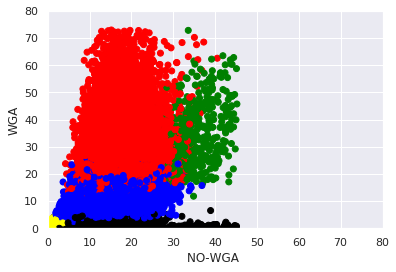

HMM labels color:  {'black': [5, 6166], 'blue': [1, 47798], 'yellow': [3, 168], 'green': [0, 491], 'red': [2, 39244]}


In [148]:
hmm_labels = []
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5}

# collect the labels as these are predicted by the HMM
for i, obs in enumerate(observations):
        
        # do not account for GAPs
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            hmm_labels.append(hmm_states_to_labels[viterbi_state])


colors = np.array(['green', 'blue', 'red', 'yellow', 'pink', 'black'])
colors = colors[hmm_labels]
       
plt.scatter(no_wga_obs, wga_obs,  color=colors)
                
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(0.0, 80.0)
plt.ylim(0.0, 80.0)
plt.show()

color_comp_assoc_hmm = {}
for label, color in zip(hmm_labels, colors):
    if color in color_comp_assoc_hmm.keys():
        assert color_comp_assoc_hmm[color][0] == label
        color_comp_assoc_hmm[color][1] += 1
    else:
        color_comp_assoc_hmm[color] = [label, 1]
        
print("HMM labels color: ", color_comp_assoc_hmm)